In [547]:
import keras
from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense, Bidirectional, Dropout
from keras.layers import Embedding
import keras.backend as K

import numpy as np
import string
import csv
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import random


In [548]:
url = "./datasets/pre_processed_dataset.csv"
names = ["tweet", "label"]
data = pd.read_csv(url,names=names)
data = data.drop(data.index[0])
data = data.sample(frac = 1)

In [549]:
X = data['tweet']
y = data['label']

# Vectorization

In [550]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [551]:
# หาความยาวสูงสุดของ senence ใน tweets
max_length = max([len(word_tokenize(i)) for i in X])

In [552]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [553]:
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' %(vocab_size))

Found 2078 unique tokens.


In [554]:
# integer encode the tweets
x_sequences = tokenizer.texts_to_sequences(X)

In [555]:
# encode the label
num_classes = 3
y = keras.utils.to_categorical(y, num_classes)

In [556]:
X = pad_sequences(x_sequences, maxlen=max_length)

# Split data

In [557]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [558]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((214, 51), (214, 3), (38, 51), (38, 3))

In [559]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

# LSTM

In [919]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((214, 51), (214, 3), (38, 51), (38, 3))

In [978]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    CuDNNLSTM(128, return_sequences=True),
    Dropout(0.25),

    CuDNNLSTM(128),
    Dropout(0.25),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])

In [979]:
batch_size=20
epochs=15

In [980]:
# model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [981]:
rmsprop = keras.optimizers.RMSprop(lr = .002)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [982]:
model.summary()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_100 (Embedding)   (None, 51, 32)            66496     
                                                                 
 cu_dnnlstm_205 (CuDNNLSTM)  (None, 51, 128)           82944     
                                                                 
 dropout_247 (Dropout)       (None, 51, 128)           0         
                                                                 
 cu_dnnlstm_206 (CuDNNLSTM)  (None, 128)               132096    
                                                                 
 dropout_248 (Dropout)       (None, 128)               0         
                                                                 
 dense_200 (Dense)           (None, 128)               16512     
                                                                 
 dropout_249 (Dropout)       (None, 128)             

In [983]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=4)

In [984]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True, callbacks=[es])

Epoch 1/15
11/11 [==============================] - 2s 65ms/step - loss: 1.0801 - accuracy: 0.4393 - val_loss: 0.8922 - val_accuracy: 0.6842
Epoch 2/15
11/11 [==============================] - 0s 21ms/step - loss: 1.1284 - accuracy: 0.4720 - val_loss: 1.6777 - val_accuracy: 0.2105
Epoch 3/15
11/11 [==============================] - 0s 19ms/step - loss: 1.1038 - accuracy: 0.4486 - val_loss: 1.0244 - val_accuracy: 0.6579
Epoch 4/15
11/11 [==============================] - 0s 18ms/step - loss: 0.9572 - accuracy: 0.5514 - val_loss: 0.8874 - val_accuracy: 0.7105
Epoch 5/15
11/11 [==============================] - 0s 18ms/step - loss: 0.7440 - accuracy: 0.6589 - val_loss: 0.9705 - val_accuracy: 0.5000
Epoch 6/15
11/11 [==============================] - 0s 19ms/step - loss: 0.5076 - accuracy: 0.8832 - val_loss: 0.7976 - val_accuracy: 0.6842
Epoch 7/15
11/11 [==============================] - 0s 18ms/step - loss: 0.2650 - accuracy: 0.9299 - val_loss: 0.8754 - val_accuracy: 0.6053
Epoch 8/15
11

In [985]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 1.2578 - accuracy: 0.6053


[1.2577860355377197, 0.6052631735801697]

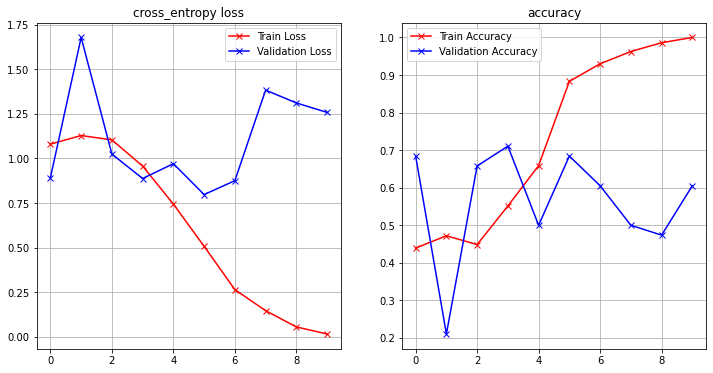

In [986]:
plot_loss_accuracy(history)

# LSTM biderectional

In [994]:
model_2 = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    Bidirectional(CuDNNLSTM(128, return_sequences=True)),
    Dropout(0.25),

    Bidirectional(CuDNNLSTM(128)),
    Dropout(0.25),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])

In [995]:
batch_size=20
epochs=15

In [996]:
rmsprop = keras.optimizers.RMSprop(lr = .002)

model_2.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [997]:
model_2.summary()

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_102 (Embedding)   (None, 51, 32)            66496     
                                                                 
 bidirectional_98 (Bidirecti  (None, 51, 256)          165888    
 onal)                                                           
                                                                 
 dropout_253 (Dropout)       (None, 51, 256)           0         
                                                                 
 bidirectional_99 (Bidirecti  (None, 256)              395264    
 onal)                                                           
                                                                 
 dropout_254 (Dropout)       (None, 256)               0         
                                                                 
 dense_204 (Dense)           (None, 128)            

In [998]:
history_2 = model_2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True, callbacks=[es])

Epoch 1/15
11/11 [==============================] - 4s 114ms/step - loss: 1.2046 - accuracy: 0.4579 - val_loss: 1.2090 - val_accuracy: 0.2105
Epoch 2/15
11/11 [==============================] - 0s 31ms/step - loss: 1.0820 - accuracy: 0.4393 - val_loss: 0.9402 - val_accuracy: 0.6842
Epoch 3/15
11/11 [==============================] - 0s 27ms/step - loss: 1.0626 - accuracy: 0.4766 - val_loss: 0.8342 - val_accuracy: 0.6842
Epoch 4/15
11/11 [==============================] - 0s 29ms/step - loss: 1.0141 - accuracy: 0.4766 - val_loss: 1.0683 - val_accuracy: 0.6842
Epoch 5/15
11/11 [==============================] - 0s 26ms/step - loss: 0.7925 - accuracy: 0.7056 - val_loss: 1.6842 - val_accuracy: 0.3158
Epoch 6/15
11/11 [==============================] - 0s 25ms/step - loss: 0.3406 - accuracy: 0.9065 - val_loss: 1.8463 - val_accuracy: 0.3947
Epoch 7/15
11/11 [==============================] - 0s 26ms/step - loss: 0.2313 - accuracy: 0.9346 - val_loss: 1.2934 - val_accuracy: 0.5789
Epoch 7: ear

In [999]:
model_2.evaluate(x_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 1.2934 - accuracy: 0.5789


[1.2933828830718994, 0.5789473652839661]

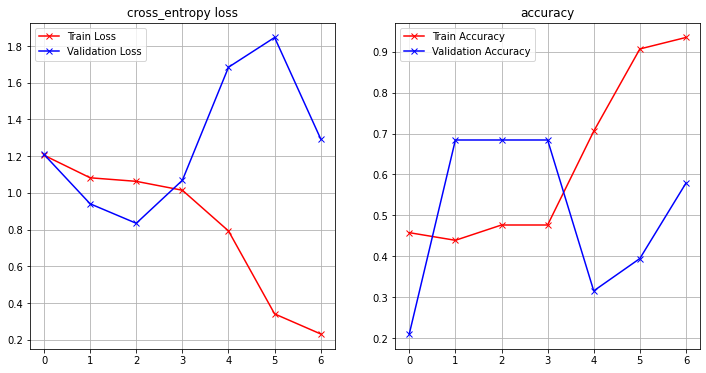

In [1000]:
plot_loss_accuracy(history_2)